# Introduction to `pandas`

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
pd.__file__

'/workspaces/hwrs564a_course_materials_guybwall/.venv/lib/python3.11/site-packages/pandas/__init__.py'

Here we'll open up some data from my GitHub account
It is snow data from Yosemite National Park for 2 locations
I am adding in some extra pieces of code to do some cleanup
- index_col=0 sets the "index" to the first column in the csv
- skipinitialspace=True makes it so " column_name" -> "column_name"
- parse_dates=True converts strings like "yyyy-mm-dd" to proper dates

In [4]:
df = pd.read_csv(
    'https://raw.githubusercontent.com/arbennett/'
    'summa_snow_layering_analysis/master/obs_data/dana_obs.csv',
    index_col=0, skipinitialspace=True, parse_dates=True
)

You can look at the first few values of data with `.head()`
Note here I did a `dropna()` first to drop the values with no
data. This only drops them before printing out the head of the
data and missing data will stay recorded in the dataframe
If you wanted to drop them for good you would do `df = df.dropna()`
But that makes some of the plots look a little funky so I'm going 
to leave them in

In [5]:
df.dropna().head()

,Tuolumne Meadows Pillow SWE [mm],Dana Meadows Pillow SWE [mm]
Date [yyyy-mm-dd],,
1980-11-10,0.0,18.0
1980-11-11,13.0,18.0
1980-11-12,25.0,18.0
1980-11-13,25.0,33.0
1980-11-14,25.0,66.0


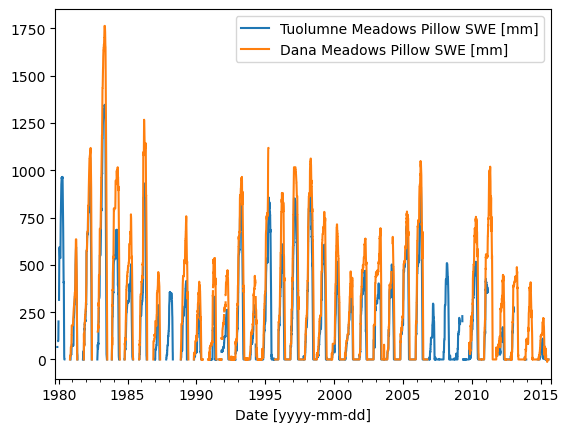

In [4]:
# Now we can start plotting easily!
df['Tuolumne Meadows Pillow SWE [mm]'].plot()
df['Dana Meadows Pillow SWE [mm]'].plot()
plt.legend()

<AxesSubplot: xlabel='Date [yyyy-mm-dd]'>

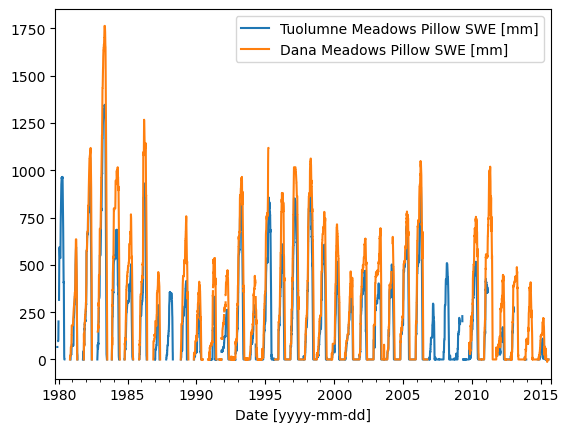

In [5]:
# Alternatively, this plots all of the columns
df.plot()

There are many ways you can plot things - here's
scatter plot. Note we need to say which columns to
put on the x and y axis. From this plot we can see
That Dana Meadows tends to get more snow

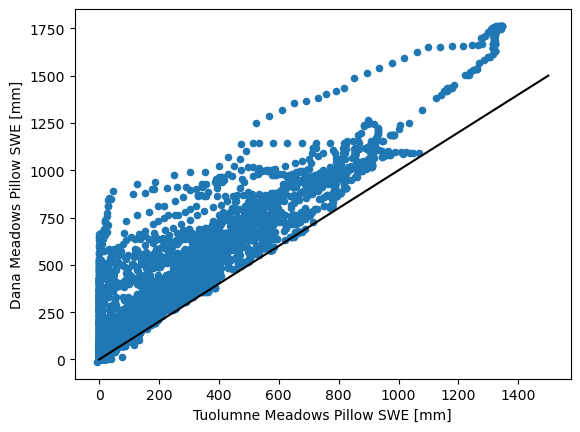

In [6]:
df.plot.scatter(
    x='Tuolumne Meadows Pillow SWE [mm]',
    y='Dana Meadows Pillow SWE [mm]'
)
# Plot a one-to-one line
plt.plot([0, 1500], [0, 1500], color='black')

One of pandas main strengths is how easy it makes
data analysis and encourages you to explore your
data in different ways. So here, we might try to
filter down some of the values and only look at the
yearly maximum data. To do this we will use a "groupby"
operation. The pandas documentation has a bunch of 
examples if you scroll down: 
  https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.groupby.html
Anyways, here we will just look at the head again, this
is always a good practice - now you'll see the index
is just yearly data rather than daily

In [9]:
yearly_max = df.groupby(df.index.year).max()
yearly_max.head()

,Tuolumne Meadows Pillow SWE [mm],Dana Meadows Pillow SWE [mm]
Date [yyyy-mm-dd],,
1979,201.0,NaN
1980,965.0,180.0
1981,594.0,635.0
1982,1067.0,1118.0
1983,1346.0,1763.0


<Axes: xlabel='Date [yyyy-mm-dd]'>

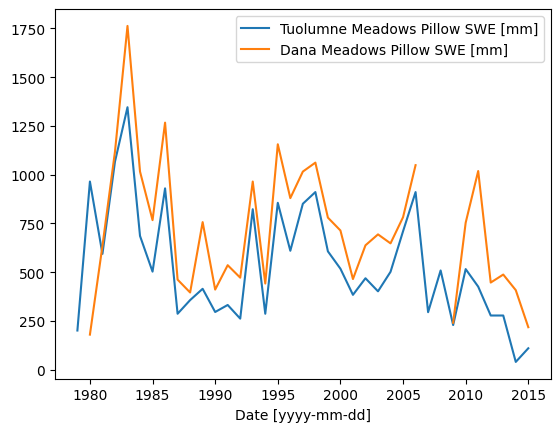

In [10]:
# Now we can plot this too
yearly_max.plot()

But maybe it would look better as a bar plot?
To do that we do `.plot.bar()` rather than `.plot()`
Alternatively, you *can* do `.plot.line()` to get the
original plot, line plots are the default.

<Axes: xlabel='Date [yyyy-mm-dd]'>

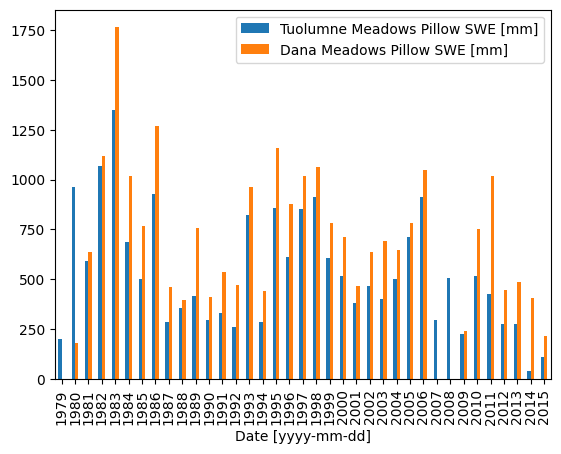

In [11]:
yearly_max.plot.bar()

Looking at the annual max is cool, but but what if we
want to know what the "average year" looks like?
To do that we can group by the "dayofyear". This
basically groups all of the January 1s together
and all of the January 2s together, and so on.
Then with each of these grouped we take the `mean`
We then plot this. I have added two vertical line
markers, one for Sept22 (which is today as of me 
writing this) and one for April 1st, which is
generally when the peak of the snow season is for
Yosemite.

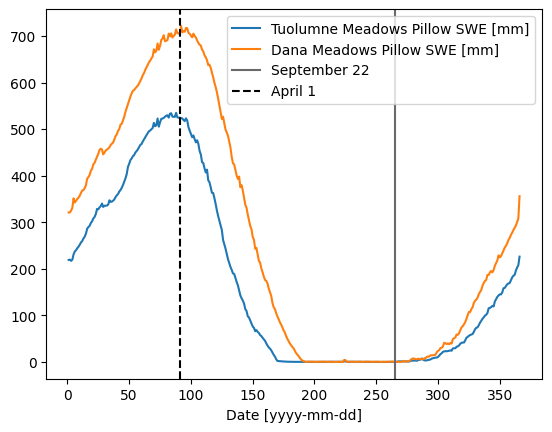

In [12]:
doy_mean = df.groupby(df.index.dayofyear).mean()
doy_mean.plot()
plt.axvline(265, label='September 22', color='dimgrey')
plt.axvline(91, label='April 1', color='black', linestyle='--')
plt.legend()

Next up, just to show how this type of plot can be
used to summarize variability as well, we will take the
median, 25th percentile (or quantile, as pandas uses it
but really it's the same thing), and 75th percentile.
And now we can plot thos for Dana meadows to show the 
variability through the snow season
                        

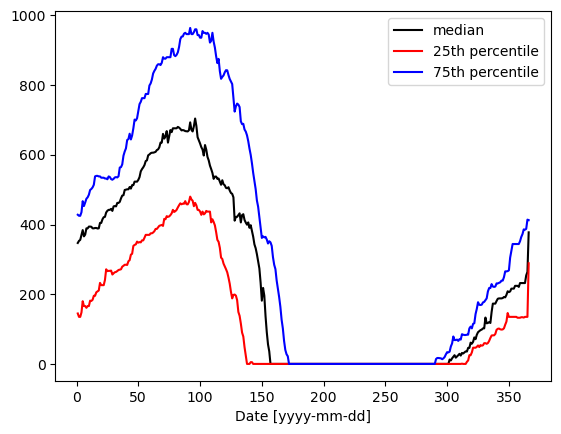

In [11]:
doy_med = df.groupby(df.index.dayofyear).median()
doy_low = df.groupby(df.index.dayofyear).quantile(0.25)
doy_high = df.groupby(df.index.dayofyear).quantile(0.75)

doy_med['Dana Meadows Pillow SWE [mm]'].plot(color='black', label='median')
doy_low['Dana Meadows Pillow SWE [mm]'].plot(color='red', label='25th percentile')
doy_high['Dana Meadows Pillow SWE [mm]'].plot(color='blue', label='75th percentile')
plt.legend()

Finally, this one is a bit more complex but it's a common
operation to do, so I'm putting it here for your reference.
In the previous day of year plots we've done some aggregation
across all of the years, but what if we just wanted to plot
each year "on top" of each other. This is known as a 
"spaghetti plot": https://www.data-to-viz.com/caveat/spaghetti.html
To do this, we actually need to create a new table where the columns
are each year, and the index is the day of the year. This can
be done with a pivot table, which is the same concept as with
spreadsheets if you are familiar: https://en.wikipedia.org/wiki/Pivot_table
Anyhow, we set it up like this:
- df: the data frame we've been working with
- index=df.index.dayofyear: The new index that will be produced
- columns=df.index.year: The new columns that will be produced
- values='Tuolumne...': The column to use from the original `df`
- aggfunc='mean': take the mean value

As is customary let's look at the head afterwards to see what we've got.
You can see it's got columns which are the years, and an index which 
just counts up. These are the "dayofyears" where 1 means January1,
2 means January2, 91 means April1, and 265 means Sept22.

In [12]:
pt = pd.pivot_table(
    df, 
    index=df.index.dayofyear, 
    columns=df.index.year,
    values='Tuolumne Meadows Pillow SWE [mm]', 
    aggfunc='mean'
)
pt.head()

Date [yyyy-mm-dd],1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
Date [yyyy-mm-dd],,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,76.0,356.0,549.0,521.0,300.0,257.0,0.0,183.0,...,356.0,82.0,109.0,129.0,162.0,408.0,49.0,278.0,NaN,43.0
2,NaN,NaN,74.0,371.0,549.0,521.0,300.0,259.0,3.0,183.0,...,381.0,82.0,109.0,132.0,162.0,420.0,55.0,278.0,NaN,43.0
3,NaN,NaN,74.0,381.0,546.0,521.0,300.0,262.0,3.0,185.0,...,457.0,85.0,109.0,135.0,162.0,426.0,46.0,278.0,NaN,43.0
4,NaN,NaN,71.0,394.0,549.0,521.0,300.0,264.0,43.0,223.0,...,457.0,85.0,115.0,132.0,162.0,423.0,31.0,278.0,NaN,43.0
5,NaN,NaN,71.0,533.0,551.0,521.0,300.0,278.0,49.0,253.0,...,457.0,115.0,210.0,135.0,159.0,405.0,28.0,278.0,NaN,43.0


And with that we can plot the spaghetti!
Note you probably want to do `legend=False` here so that
you don't have a legend which has all 37 lines on it. 
Similarly we make all the of the lines grey just so it's
a bit less aggressive on the eyes. 

<AxesSubplot: xlabel='Date [yyyy-mm-dd]'>

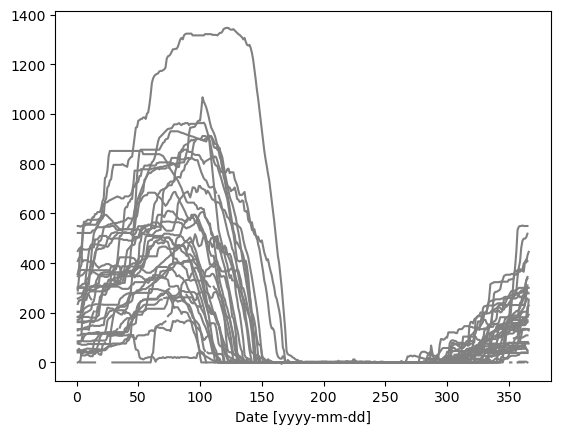

In [13]:
pt.plot(legend=False, color='grey')